## Problem Description

<div class="alert alert-block alert-info">

A US-based housing company named housingrise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia. The data is provided in the CSV file below.

The company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:

- Which variables are significant in predicting the price of a house, and

- How well those variables describe the price of a house.


Also, determine the optimal value of lambda for ridge and lasso regression.
## Business Goal 

You are required to model the price of houses with the available independent variables. This model will then be used by the management to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.
</div>

# Basic component used information
<div class="alert alert-block alert-info">
Python version: 3.8.5 Numpy version : 1.19.2 Pandas version : 1.1.3 Seaborn version : 0.11.0
</div>         

<div class="alert alert-block alert-info">
    <h1> Import required modules</h1>
</div>     

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score
import scipy as sp
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.width', 200)
dtype={'user_id': int}
#Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

## Step:1 Understanding the dataset

In [2]:
# reading the dataset
housing = pd.read_csv("train.csv")
housing.head()
#housing.drop(['OverallCond','LowQualFinSF','BsmtFullBath','Neighborhood','ExterCond'], axis=1, inplace=True)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
print(housing.shape)

(1460, 81)


#### NULL value treatment

In [5]:
nulls = housing.isnull().sum()
nulls = ((nulls[nulls>0]/housing.shape[0])*100).sort_values(ascending = False)
print(nulls.head(30))

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


<div class="alert alert-danger">
Few columns have lot of empty values. But analyze the columns data if dropping those with more than 80% nulls will not impact the model.
</div>   

<div class="alert alert-info">
    <h3>Tried two approaches</h3>
    <ul>
        <li>Removing columns containing 80% null (a guideline provided in one of the mentor session)</li>
    <li>Imputing values as per Data Dictionary of columns having nans</li>
    </ul>
    Approach 2 gives better result in terms of R2 for both Ridge and Lasso. So selecting 2nd approach.

In [6]:
# Approach 1:
# More than 50 columns have almost all empty values.
# Good to drop columns containg 80% of NaNs (80% is considered as a guideline provided in one of the mentor session)
#min_percentage_nan_allowed = 20.00
#min_valid_values_allowed =  int(((100-min_percentage_nan_allowed)/100)*housing.shape[0] + 1) #Calculate (100-min_percentage_nan_allowed)% of non-NaN values below which all columns wil be dropped
#print(min_valid_values_allowed)
# Drop all columns which have 80% of NaN values
#housing = housing.dropna(axis=1,how='any', 
#               thresh=min_valid_values_allowed)

# Approach 2:
#From data dictionary 
#PoolQC - All missing data which is marked NA means 'No Pool'. So lets replace all nans to "NA"
#MiscFeature - All missing data which is marked NA means 'MiscFeature'. Not clear what does it mean. Let's drop this.
#Alley - All missing data which is marked NA means 'No alley access'. So lets replace all nans to "NA"
#Fence - All missing data which is marked NA means 'No Fence'. So lets replace all nans to "NA"
#FireplaceQu - All missing data which is marked NA means 'No Fence'. So lets replace all nans to "NA"

housing.PoolQC = housing.PoolQC.replace(np.nan, 'NoPool')
housing.MiscFeature = housing.MiscFeature.replace(np.nan, 'MiscFeature')
housing.Alley = housing.Alley.replace(np.nan, 'Noalleyaccess')
housing.Fence = housing.Fence.replace(np.nan, 'NoFence')
housing.FireplaceQu = housing.FireplaceQu.replace(np.nan, 'NoFence')

In [7]:
nulls = (housing.isnull().mean() * 100).sort_values(ascending = False)
nulls.head(20)

LotFrontage     17.739726
GarageYrBlt      5.547945
GarageCond       5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
LotShape         0.000000
RoofMatl         0.000000
Exterior1st      0.000000
Exterior2nd      0.000000
Foundation       0.000000
ExterQual        0.000000
dtype: float64

#### Analyze LotFrontage

In [8]:
housing.LotFrontage.unique()

array([ 65.,  80.,  68.,  60.,  84.,  85.,  75.,  nan,  51.,  50.,  70.,
        91.,  72.,  66., 101.,  57.,  44., 110.,  98.,  47., 108., 112.,
        74., 115.,  61.,  48.,  33.,  52., 100.,  24.,  89.,  63.,  76.,
        81.,  95.,  69.,  21.,  32.,  78., 121., 122.,  40., 105.,  73.,
        77.,  64.,  94.,  34.,  90.,  55.,  88.,  82.,  71., 120., 107.,
        92., 134.,  62.,  86., 141.,  97.,  54.,  41.,  79., 174.,  99.,
        67.,  83.,  43., 103.,  93.,  30., 129., 140.,  35.,  37., 118.,
        87., 116., 150., 111.,  49.,  96.,  59.,  36.,  56., 102.,  58.,
        38., 109., 130.,  53., 137.,  45., 106., 104.,  42.,  39., 144.,
       114., 128., 149., 313., 168., 182., 138., 160., 152., 124., 153.,
        46.])

In [9]:
housing.LotFrontage.fillna(round(housing.LotFrontage.mean()), inplace=True)

#### Analyze Garage specific variables - GarageFinish, GarageCond, GarageYrBlt, GarageFinish, GarageQual,GarageType

* BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual - NA means 'No Basement'. So lets replace them with "NA".
* GarageFinish, GarageCond, GarageFinish, GarageQual, GarageType are categorial variable where NA means 'No Garage'. So lets replace them with "No Garage"
* GarageYrBlt is a continuous variable for year garage built. Can use median to fill NA.


In [10]:
housing.GarageFinish = housing.GarageFinish.replace(np.nan, 'NoGarage')
housing.GarageCond = housing.GarageCond.replace(np.nan, 'NoGarage')
housing.GarageFinish = housing.GarageFinish.replace(np.nan, 'NoGarage')
housing.GarageQual = housing.GarageQual.replace(np.nan, 'NoGarage')
housing.GarageType = housing.GarageType.replace(np.nan, 'NoGarage')

housing.BsmtFinType2 = housing.BsmtFinType2.replace(np.nan, 'NoBasement')
housing.BsmtExposure = housing.BsmtExposure.replace(np.nan, 'NoBasement')
housing.BsmtFinType1 = housing.BsmtFinType1.replace(np.nan, 'NoBasement')
housing.BsmtCond = housing.BsmtCond.replace(np.nan, 'NoBasement')
housing.BsmtQual = housing.BsmtQual.replace(np.nan, 'NoBasement')

housing.GarageYrBlt= housing.GarageYrBlt.fillna(0)

In [11]:
nulls = (housing.isnull().mean() * 100).sort_values(ascending = False)
nulls.head(10)

MasVnrType     0.547945
MasVnrArea     0.547945
Electrical     0.068493
SalePrice      0.000000
Foundation     0.000000
RoofMatl       0.000000
Exterior1st    0.000000
Exterior2nd    0.000000
ExterQual      0.000000
ExterCond      0.000000
dtype: float64

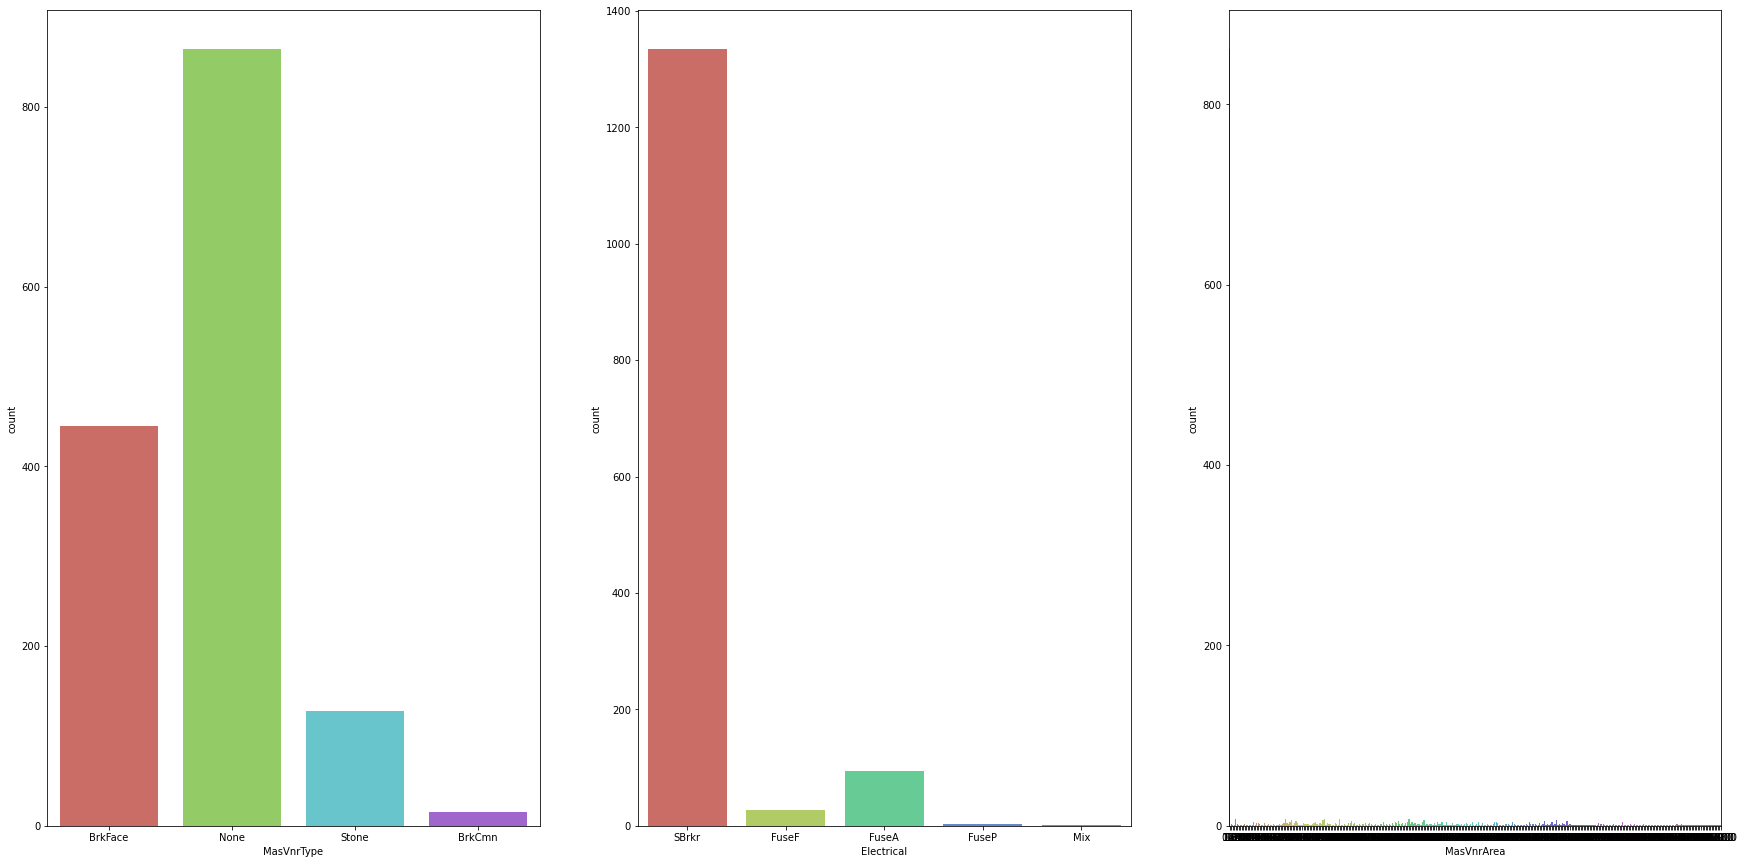

In [12]:
plt.figure(figsize=(30, 15))
plt.subplot(1,3,1)
sns.countplot(x="MasVnrType", data=housing, palette="hls")
plt.subplot(1,3,2)
sns.countplot(x="Electrical", data=housing, palette="hls")
plt.subplot(1,3,3)
sns.countplot(x="MasVnrArea", data=housing, palette="hls")
plt.show()

In [13]:
housing.MasVnrArea

0       196.0
1         0.0
2       162.0
3         0.0
4       350.0
        ...  
1455      0.0
1456    119.0
1457      0.0
1458      0.0
1459      0.0
Name: MasVnrArea, Length: 1460, dtype: float64

<div class="alert alert-info">
Let's fill MasVnrType and Electrical with value occuring most and MasVnrArea with mean.
</div>

In [14]:
housing.MasVnrType = housing.MasVnrType.replace(np.nan, 'None') # replacing nan with the top option of this field
housing.Electrical = housing.Electrical.replace(np.nan, 'SBrkr') # replacing nan with the top option of this field
housing.MasVnrArea= housing.MasVnrArea.fillna(housing.MasVnrArea.mean())  # replacing nan with mean

In [15]:
nulls = (housing.isnull().mean() * 100).sort_values(ascending = False)
nulls.head(10)

SalePrice      0.0
Heating        0.0
RoofStyle      0.0
RoofMatl       0.0
Exterior1st    0.0
Exterior2nd    0.0
MasVnrType     0.0
MasVnrArea     0.0
ExterQual      0.0
ExterCond      0.0
dtype: float64

<div class="alert alert-success">
<h1>We have now columns with all valid values.
</div>

### Analyze data to find irrelevant columns

In [16]:
nulls = (housing.nunique()).sort_values(ascending = False)
print(nulls.head(30))

Id               1460
LotArea          1073
GrLivArea         861
BsmtUnfSF         780
1stFlrSF          753
TotalBsmtSF       721
SalePrice         663
BsmtFinSF1        637
GarageArea        441
2ndFlrSF          417
MasVnrArea        328
WoodDeckSF        274
OpenPorchSF       202
BsmtFinSF2        144
EnclosedPorch     120
YearBuilt         112
LotFrontage       110
GarageYrBlt        98
ScreenPorch        76
YearRemodAdd       61
Neighborhood       25
LowQualFinSF       24
MiscVal            21
3SsnPorch          20
Exterior2nd        16
Exterior1st        15
MSSubClass         15
TotRmsAbvGrd       12
MoSold             12
OverallQual        10
dtype: int64


<div class="alert alert-info">
ID looks irrelevant so can be dropped
</div>

In [17]:
housing.drop('Id', axis=1, inplace=True)

In [18]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [19]:
housing.Street

0       Pave
1       Pave
2       Pave
3       Pave
4       Pave
        ... 
1455    Pave
1456    Pave
1457    Pave
1458    Pave
1459    Pave
Name: Street, Length: 1460, dtype: object

## Step 2: EDA
### 2.1 Univariate Analysis

In [20]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

#### Analyze data for outliers

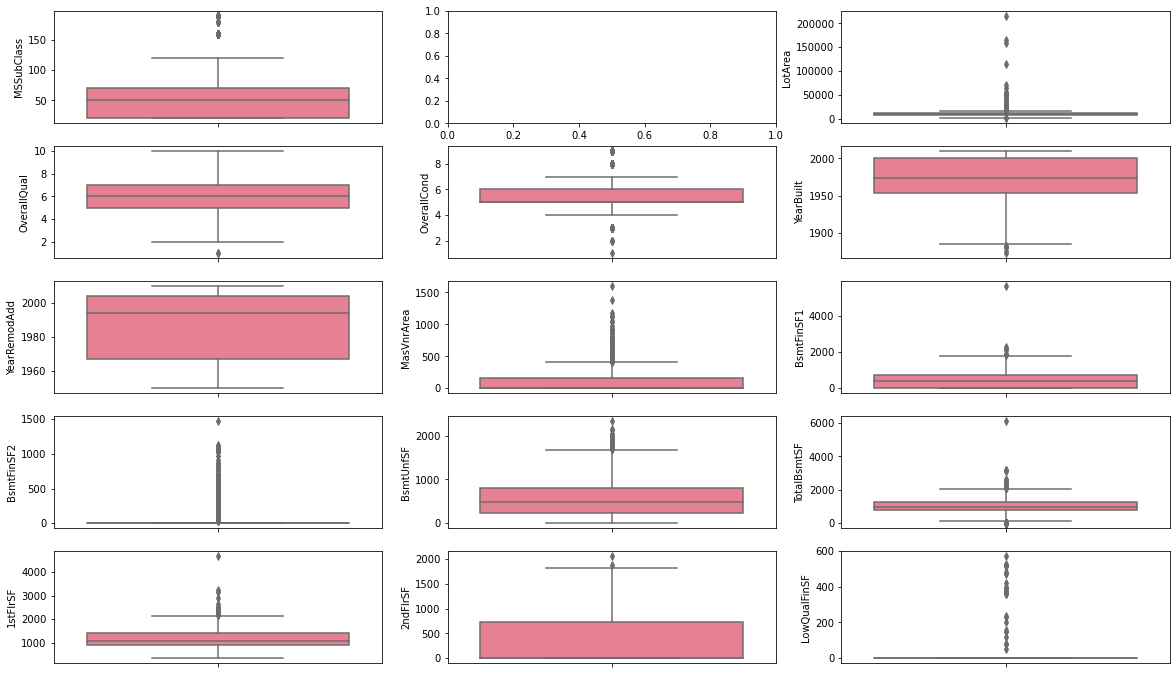

In [21]:
plt.figure(figsize=(20, 12))
plt.subplot(5,3,1)
sns.boxplot(y=housing.MSSubClass, palette="husl")
plt.subplot(5,3,2)
#sns.boxplot(y=housing.LotFrontage, palette="husl")
plt.subplot(5,3,3)
sns.boxplot(y=housing.LotArea, palette="husl")
plt.xticks(rotation=90)
plt.subplot(5,3,4)
sns.boxplot(y=housing.OverallQual, palette="husl")
plt.subplot(5,3,5)
sns.boxplot(y=housing.OverallCond, palette="husl")
plt.subplot(5,3,6)
sns.boxplot(y=housing.YearBuilt, palette="husl")
plt.subplot(5,3,7)
sns.boxplot(y=housing.YearRemodAdd, palette="husl")
plt.subplot(5,3,8)
sns.boxplot(y=housing.MasVnrArea, palette="husl")
plt.subplot(5,3,9)
sns.boxplot(y=housing.BsmtFinSF1, palette="husl")
plt.subplot(5,3,10)
sns.boxplot(y=housing.BsmtFinSF2, palette="husl")
plt.subplot(5,3,11)
sns.boxplot(y=housing.BsmtUnfSF, palette="husl")
plt.subplot(5,3,12)
sns.boxplot(y=housing.TotalBsmtSF, palette="husl")
plt.subplot(5,3,13)
sns.boxplot(y=housing['1stFlrSF'], palette="husl")
plt.subplot(5,3,14)
sns.boxplot(y=housing['2ndFlrSF'], palette="husl")
plt.subplot(5,3,15)
sns.boxplot(y=housing.LowQualFinSF, palette="husl")

plt.show()

<div class="alert alert-danger">
    <ul>
  <li>LotFrontage</li>
  <li>LotArea</li>
  <li>OverallCond</li>
  <li>MasVnrArea</li>
  <li>BsmtUnfSF</li>
  <li>LowQualFinSF</li>
</ul> 
    Above columns have lot of outliers.
</div>

In [22]:
print(housing.BsmtFinSF2.value_counts())
#print(housing.LowQualFinSF.value_counts())

0       1293
180        5
374        3
551        2
93         2
        ... 
532        1
544        1
546        1
547        1
1474       1
Name: BsmtFinSF2, Length: 144, dtype: int64


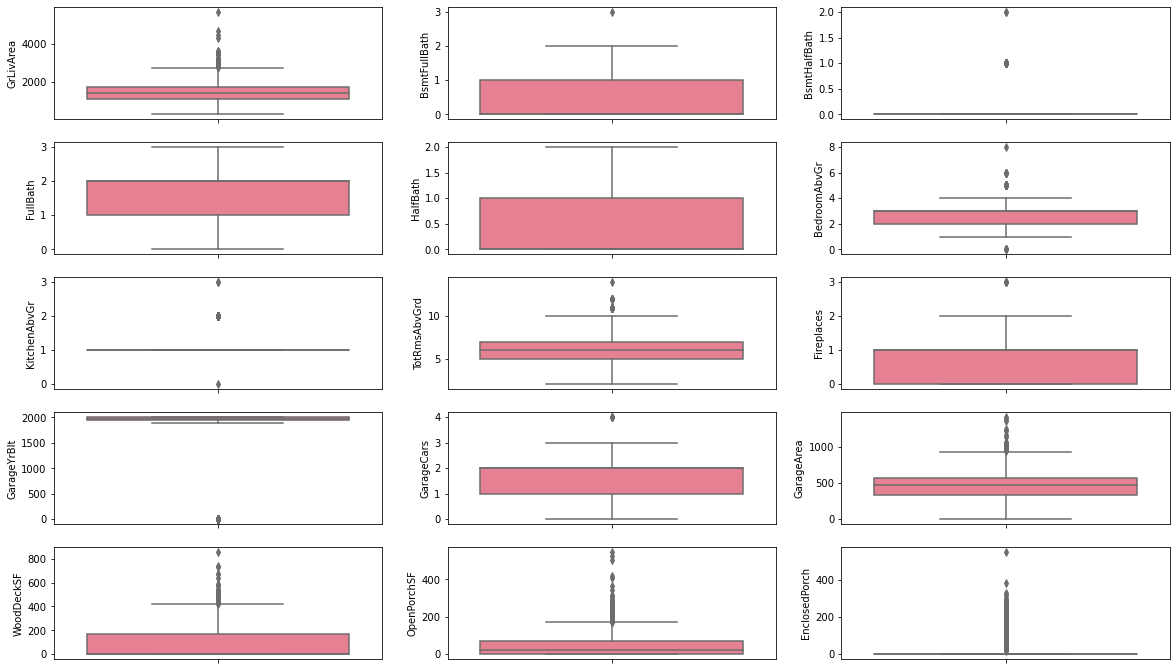

In [23]:

plt.figure(figsize=(20, 12))
plt.subplot(5,3,1)
sns.boxplot(y=housing.GrLivArea, palette="husl")
plt.subplot(5,3,2)
sns.boxplot(y=housing.BsmtFullBath, palette="husl")
plt.subplot(5,3,3)
sns.boxplot(y=housing.BsmtHalfBath, palette="husl")
plt.xticks(rotation=90)
plt.subplot(5,3,4)
sns.boxplot(y=housing.FullBath, palette="husl")
plt.subplot(5,3,5)
sns.boxplot(y=housing.HalfBath, palette="husl")

plt.subplot(5,3,6)
sns.boxplot(y=housing.BedroomAbvGr, palette="husl")
plt.subplot(5,3,7)
sns.boxplot(y=housing.KitchenAbvGr, palette="husl")
plt.subplot(5,3,8)
sns.boxplot(y=housing.TotRmsAbvGrd, palette="husl")
plt.subplot(5,3,9)
sns.boxplot(y=housing.Fireplaces, palette="husl")
plt.subplot(5,3,10)
sns.boxplot(y=housing.GarageYrBlt, palette="husl")
plt.subplot(5,3,11)
sns.boxplot(y=housing.GarageCars, palette="husl")
plt.subplot(5,3,12)
sns.boxplot(y=housing.GarageArea, palette="husl")
plt.subplot(5,3,13)
sns.boxplot(y=housing.WoodDeckSF, palette="husl")
plt.subplot(5,3,14)
sns.boxplot(y=housing.OpenPorchSF, palette="husl")
plt.subplot(5,3,15)
sns.boxplot(y=housing.EnclosedPorch, palette="husl")

plt.show()

In [24]:
#BsmtHalfBath,EnclosedPorch and KitchenAbvGr boxplot do not look good. Lets analyze:
print(housing.BsmtHalfBath.value_counts())
print(housing.KitchenAbvGr.value_counts())
print(housing.EnclosedPorch.value_counts())

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64
1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64
0      1252
112      15
96        6
120       5
144       5
       ... 
174       1
177       1
183       1
189       1
552       1
Name: EnclosedPorch, Length: 120, dtype: int64


<AxesSubplot:ylabel='YrSold'>

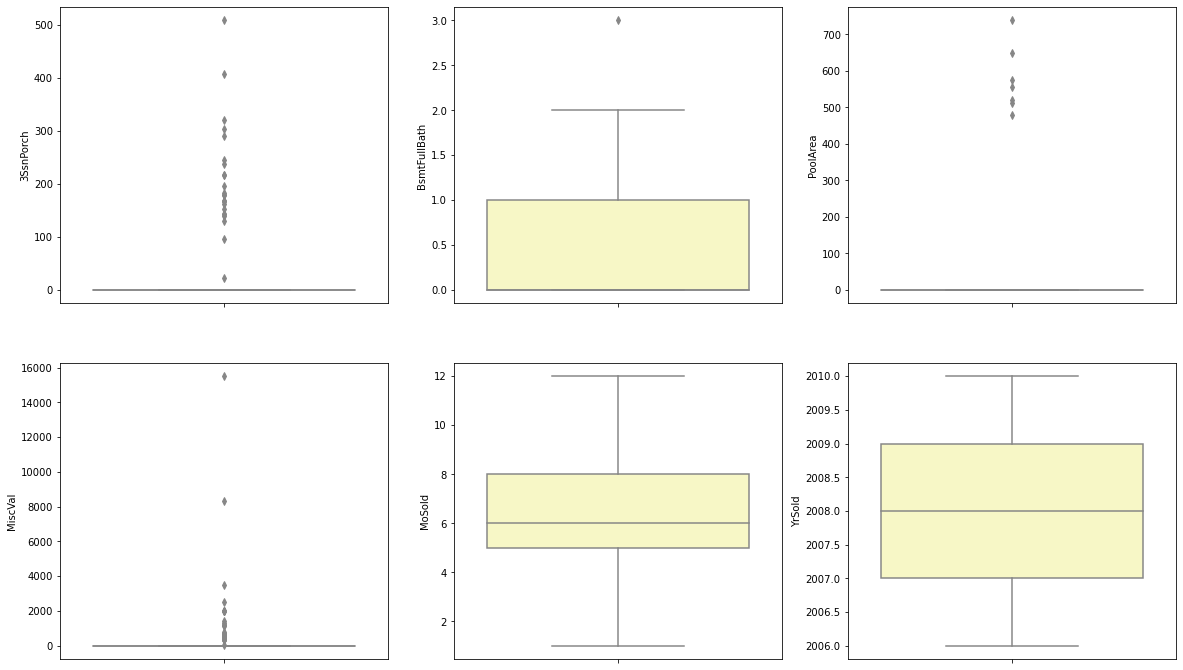

In [25]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(y=housing['3SsnPorch'], palette="Spectral")
plt.subplot(2,3,2)
sns.boxplot(y=housing.BsmtFullBath, palette="Spectral")
plt.subplot(2,3,3)
sns.boxplot(y=housing.PoolArea, palette="Spectral")
plt.xticks(rotation=90)
plt.subplot(2,3,4)
sns.boxplot(y=housing.MiscVal, palette="Spectral")
plt.subplot(2,3,5)
sns.boxplot(y=housing.MoSold, palette="Spectral")
plt.subplot(2,3,6)
sns.boxplot(y=housing.YrSold, palette="Spectral")

In [26]:
print(housing['3SsnPorch'].value_counts())
print(housing.PoolArea.value_counts())
print(housing.MiscVal.value_counts())

0      1436
168       3
216       2
144       2
180       2
245       1
238       1
290       1
196       1
182       1
407       1
304       1
162       1
153       1
320       1
140       1
130       1
96        1
23        1
508       1
Name: 3SsnPorch, dtype: int64
0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64
0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64


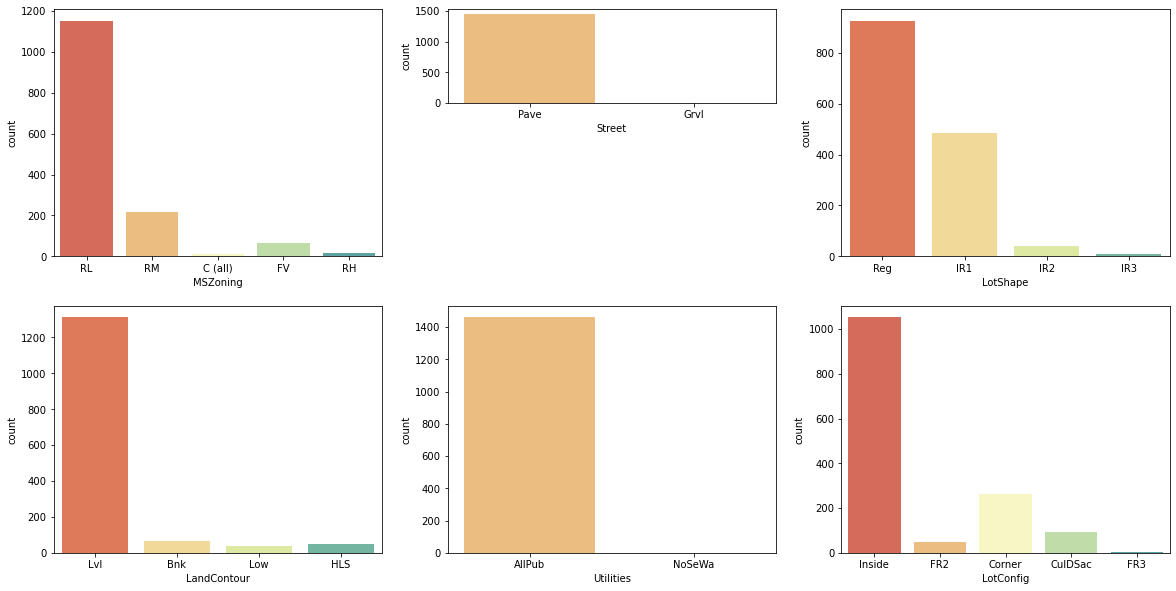

In [27]:
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
sns.countplot(x='MSZoning', data=housing, palette="Spectral")
plt.subplot(5,3,2)
sns.countplot(x='Street', data=housing, palette="Spectral")
plt.subplot(2,3,3)
sns.countplot(x='LotShape', data=housing, palette="Spectral")
plt.subplot(2,3,4)
sns.countplot(x='LandContour', data=housing, palette="Spectral")
plt.subplot(2,3,5)
sns.countplot(x='Utilities', data=housing, palette="Spectral")
plt.subplot(2,3,6)
sns.countplot(x='LotConfig', data=housing, palette="Spectral")
plt.show()



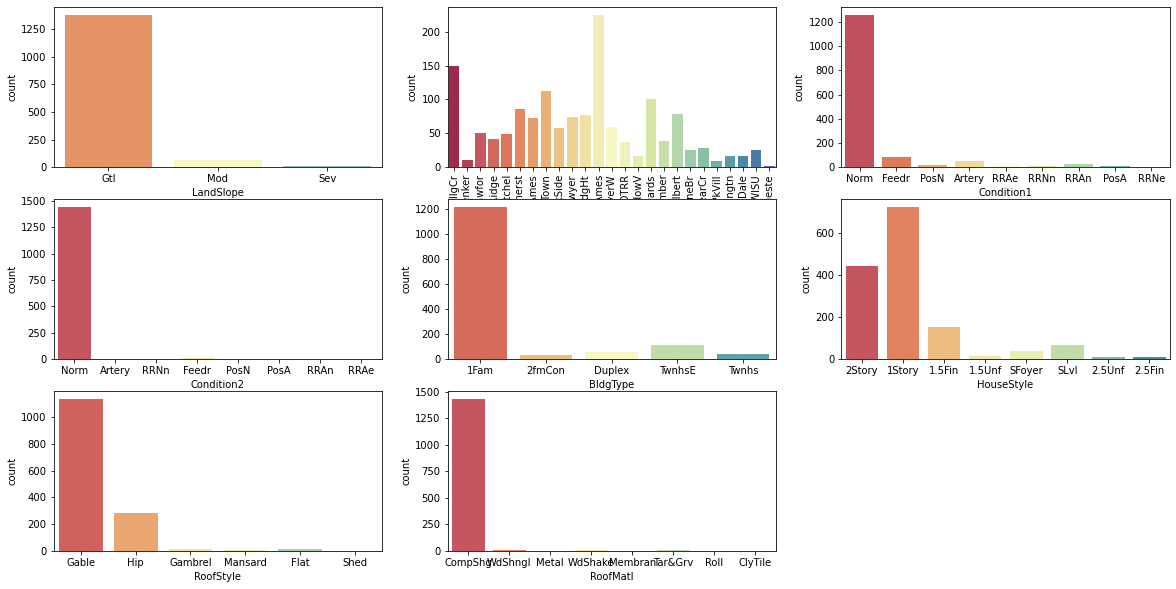

In [28]:
plt.figure(figsize=(20, 10))
plt.subplot(3,3,1)
sns.countplot(x='LandSlope', data=housing, palette="Spectral")
plt.subplot(3,3,2)
sns.countplot(x='Neighborhood', data=housing, palette="Spectral")
plt.xticks(rotation=90)
plt.subplot(3,3,3)
sns.countplot(x='Condition1', data=housing, palette="Spectral")
plt.subplot(3,3,4)
sns.countplot(x='Condition2', data=housing, palette="Spectral")
plt.subplot(3,3,5)
sns.countplot(x='BldgType', data=housing, palette="Spectral")
plt.subplot(3,3,6)
sns.countplot(x='HouseStyle', data=housing, palette="Spectral")
plt.subplot(3,3,7)
sns.countplot(x='RoofStyle', data=housing, palette="Spectral")
plt.subplot(3,3,8)
sns.countplot(x='RoofMatl', data=housing, palette="Spectral")
plt.show()

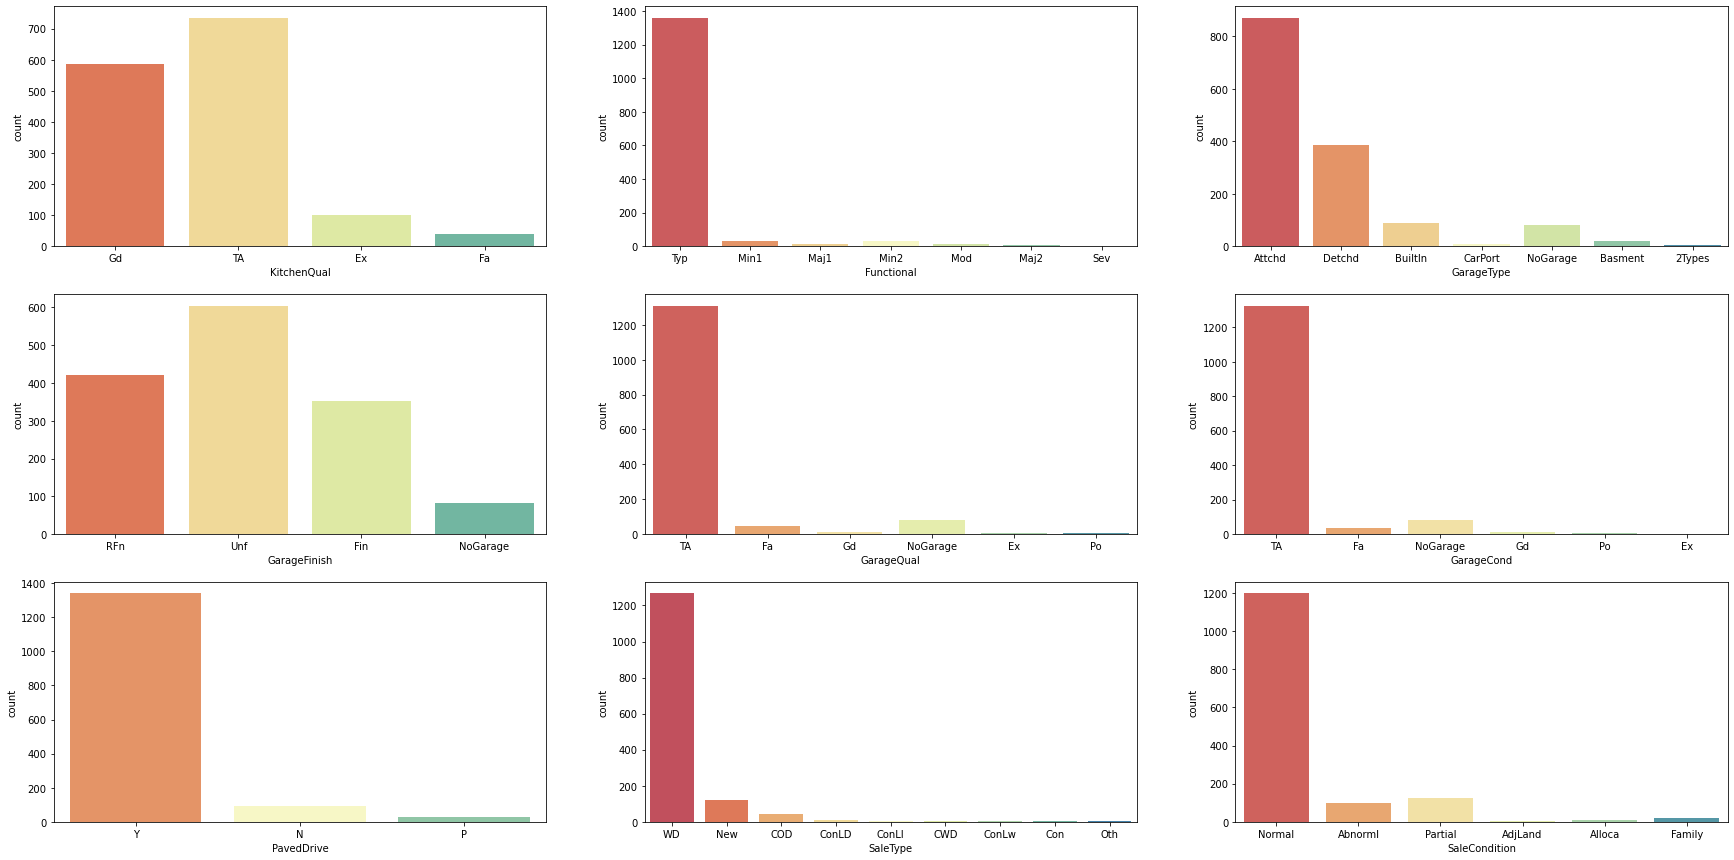

In [29]:
plt.figure(figsize=(30, 15))
plt.subplot(3,3,1)
sns.countplot(x='KitchenQual', data=housing, palette="Spectral")
plt.subplot(3,3,2)
sns.countplot(x='Functional', data=housing, palette="Spectral")
plt.subplot(3,3,3)
sns.countplot(x='GarageType', data=housing, palette="Spectral")
plt.subplot(3,3,4)
sns.countplot(x='GarageFinish', data=housing, palette="Spectral")
plt.subplot(3,3,5)
sns.countplot(x='GarageQual', data=housing, palette="Spectral")
plt.subplot(3,3,6)
sns.countplot(x='GarageCond', data=housing, palette="Spectral")
plt.subplot(3,3,7)
sns.countplot(x='PavedDrive', data=housing, palette="Spectral")
plt.subplot(3,3,8)
sns.countplot(x='SaleType', data=housing, palette="Spectral")
plt.subplot(3,3,9)
sns.countplot(x='SaleCondition', data=housing, palette="Spectral")
plt.show()

<div class="alert alert-danger">
    <h1>Analysis</h1>
<div class="alert alert-danger">
    <h2>Categorical Predictors</h2>
    Below columns have lot of outliers.
<ul>
  <li>LotFrontage</li>
  <li>LotArea</li>
  <li>OverallCond</li>
  <li>MasVnrArea</li>
  <li>BsmtUnfSF</li>
  <li>LowQualFinSF</li>
  <li>GrLivArea</li>
  <li>GarageArea</li>
  <li>WoodDeckSF</li>
  <li>OpenPorchSF</li>
  <li>EnclosedPorch</li>
  <li>BsmtHalfBath</li>
  <li>EnclosedPorch</li>
  <li>KitchenAbvGr</li>
  <li>3SsnPorch']</li>
  <li>PoolArea</li>
  <li>MiscVal</li>
</ul>
    From the above columns <b>BsmtFinSF2, LowQualFinSF, BsmtHalfBath, KitchenAbvGr, EnclosedPorch, 3SsnPorch, PoolArea, MiscVal, BsmtFinSF2, LowQualFinSF</b> seems to be biased towards specific values.Probably can be dropped but might give important insight. Bivariate analysis will be analyzed.
    <h2>Continuous Predictors</h2>
    Below columns have lot of outliers.
<ul>
  <li>LotFrontage</li>
  <li>LotArea</li>
  <li>OverallCond</li>
  <li>MasVnrArea</li>
  <li>BsmtUnfSF</li>
  <li>LowQualFinSF</li>
  <li>GrLivArea</li>
  <li>GarageArea</li>
  <li>WoodDeckSF</li>
  <li>OpenPorchSF</li>
  <li>EnclosedPorch</li>
  <li>BsmtHalfBath</li>
  <li>EnclosedPorch</li>
  <li>KitchenAbvGr</li>
  <li>3SsnPorch']</li>
  <li>PoolArea</li>
  <li>MiscVal</li>
</ul> 
        <b>Street, LandContour, Utilities,LandSlope, LandSlope, Condition2,PavedDrive,Functional, GarageQual</b> look quite biased towards specific value. But not dropping until bivariate analysis is performed.
</div>

## 2.2 Bivariate/Segmented Univariate Analysis¶
1. Boxplot - used for category-continuous variable analysis
2. Barplot - used for category-continuous variable analysis
3. countplots - used for category-category or category-continuous variable analysis
4. catplot - used for category-category variable analysis

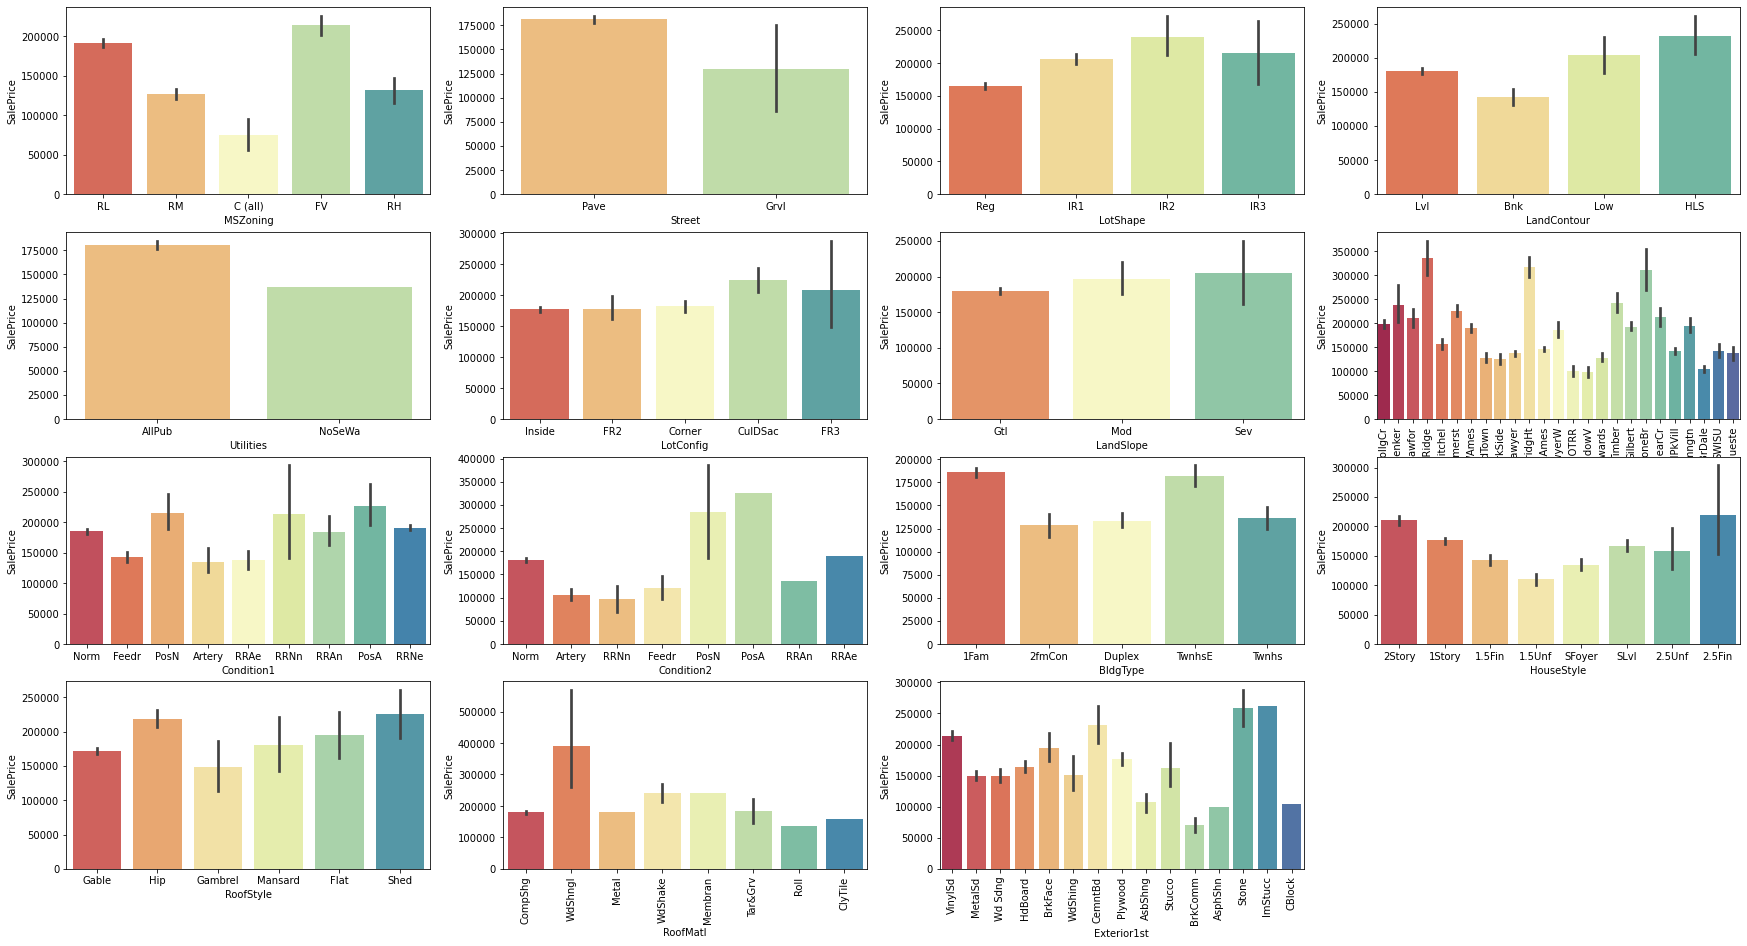

In [30]:
#Analyze continuous(SalePrice) and other categorical variables.
plt.figure(figsize=(30, 20))
plt.subplot(5,4,1)
sns.barplot(x=housing.MSZoning, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,2)
sns.barplot(x=housing.Street, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,3)
sns.barplot(x=housing.LotShape, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,4)
sns.barplot(x=housing.LandContour, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,5)
sns.barplot(x=housing.Utilities, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,6)
sns.barplot(x=housing.LotConfig, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,7)
sns.barplot(x=housing.LandSlope, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,8)
sns.barplot(x=housing.Neighborhood, y=housing.SalePrice,palette="Spectral")
plt.xticks(rotation=90)
plt.subplot(5,4,9)
sns.barplot(x=housing.Condition1, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,10)
sns.barplot(x=housing.Condition2, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,11)
sns.barplot(x=housing.BldgType, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,12)
sns.barplot(x=housing.HouseStyle, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,13)
sns.barplot(x=housing.RoofStyle, y=housing.SalePrice,palette="Spectral")
plt.subplot(5,4,14)
sns.barplot(x=housing.RoofMatl, y=housing.SalePrice,palette="Spectral")
plt.xticks(rotation=90)
plt.subplot(5,4,15)
sns.barplot(x=housing.Exterior1st, y=housing.SalePrice,palette="Spectral")
plt.xticks(rotation=90)
plt.show()

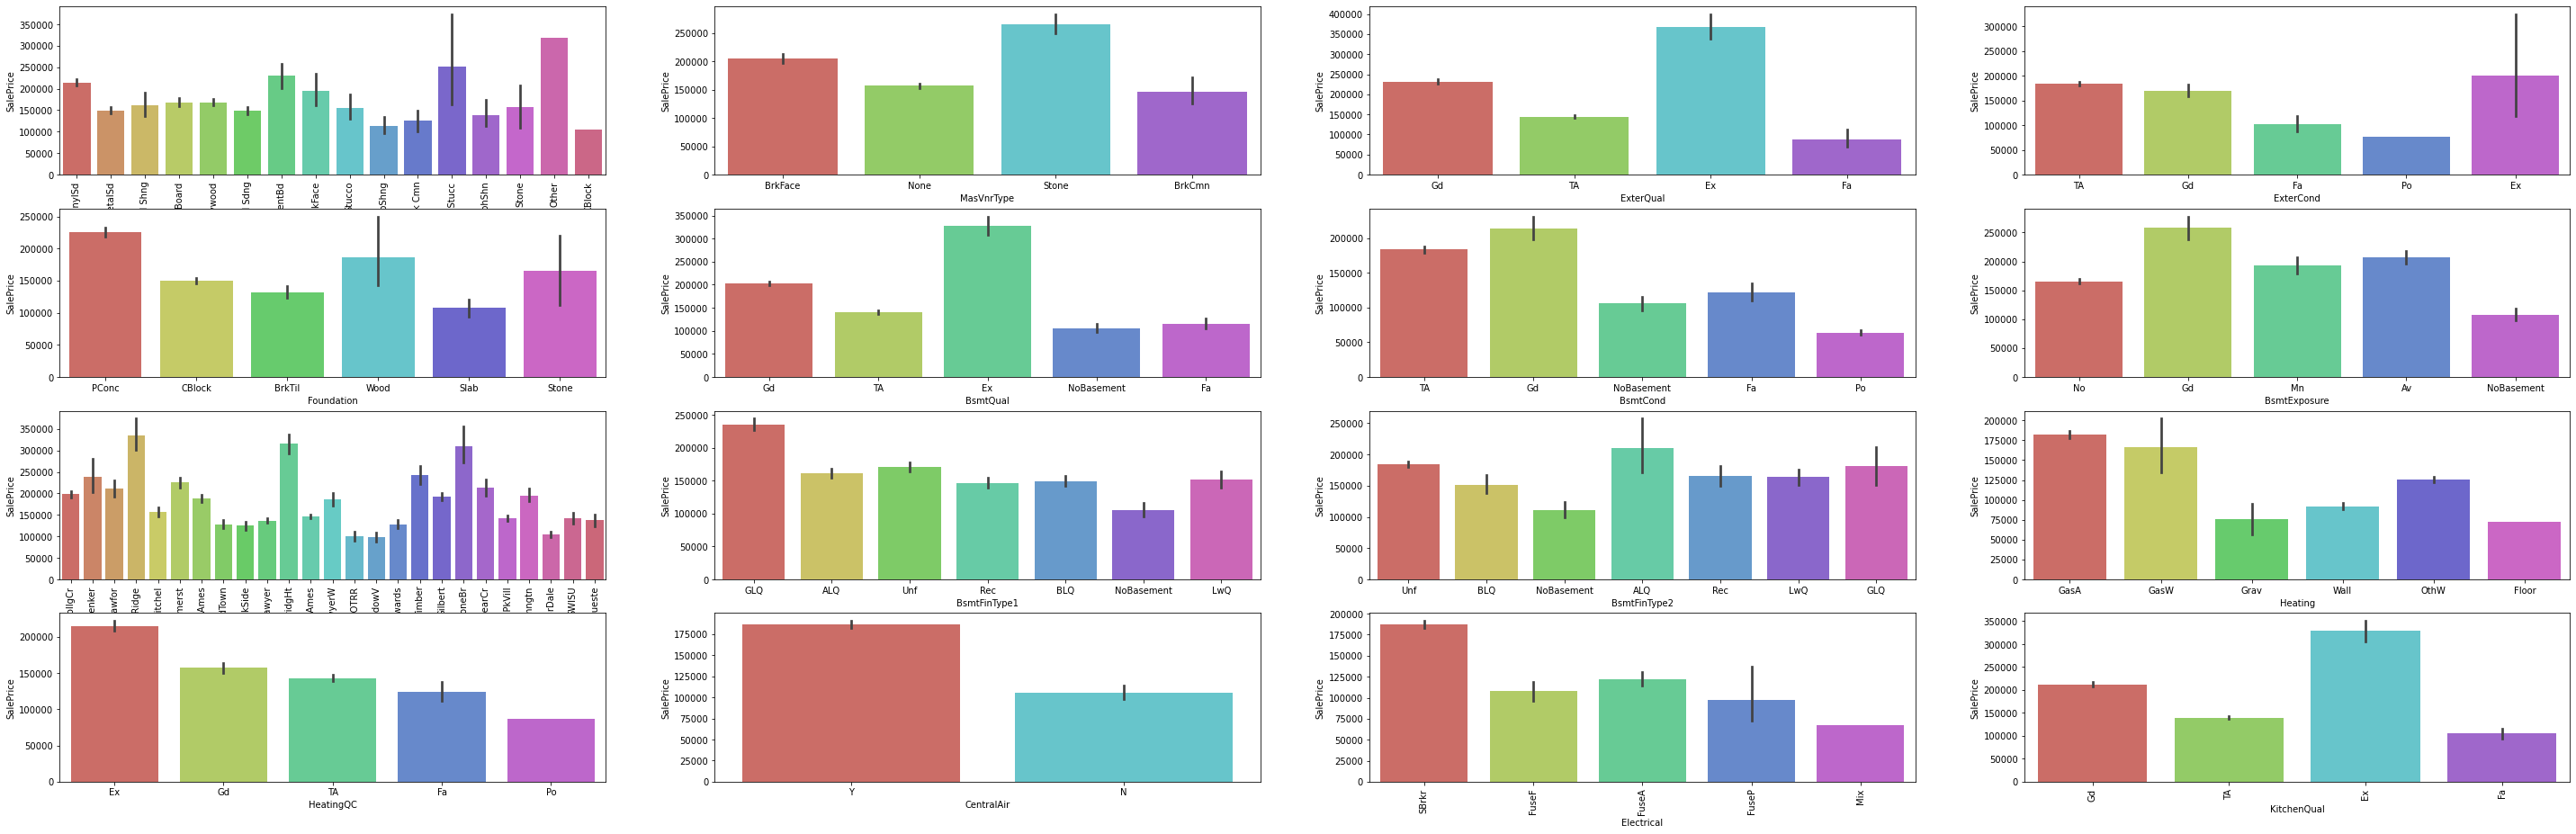

In [31]:
plt.figure(figsize=(50, 20))
plt.subplot(5,4,1)
sns.barplot(x=housing.Exterior2nd, y=housing.SalePrice,palette="hls")
plt.xticks(rotation=90)
plt.subplot(5,4,2)
sns.barplot(x=housing.MasVnrType, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,3)
sns.barplot(x=housing.ExterQual, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,4)
sns.barplot(x=housing.ExterCond, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,5)
sns.barplot(x=housing.Foundation, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,6)
sns.barplot(x=housing.BsmtQual, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,7)
sns.barplot(x=housing.BsmtCond, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,8)
sns.barplot(x=housing.BsmtExposure, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,9)
sns.barplot(x=housing.Neighborhood, y=housing.SalePrice,palette="hls")
plt.xticks(rotation=90)
plt.subplot(5,4,10)
sns.barplot(x=housing.BsmtFinType1, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,11)
sns.barplot(x=housing.BsmtFinType2, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,12)
sns.barplot(x=housing.Heating, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,13)
sns.barplot(x=housing.HeatingQC, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,14)
sns.barplot(x=housing.CentralAir, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,15)
sns.barplot(x=housing.Electrical, y=housing.SalePrice,palette="hls")
plt.xticks(rotation=90)
plt.subplot(5,4,16)
sns.barplot(x=housing.KitchenQual, y=housing.SalePrice,palette="hls")
plt.xticks(rotation=90)
plt.show()




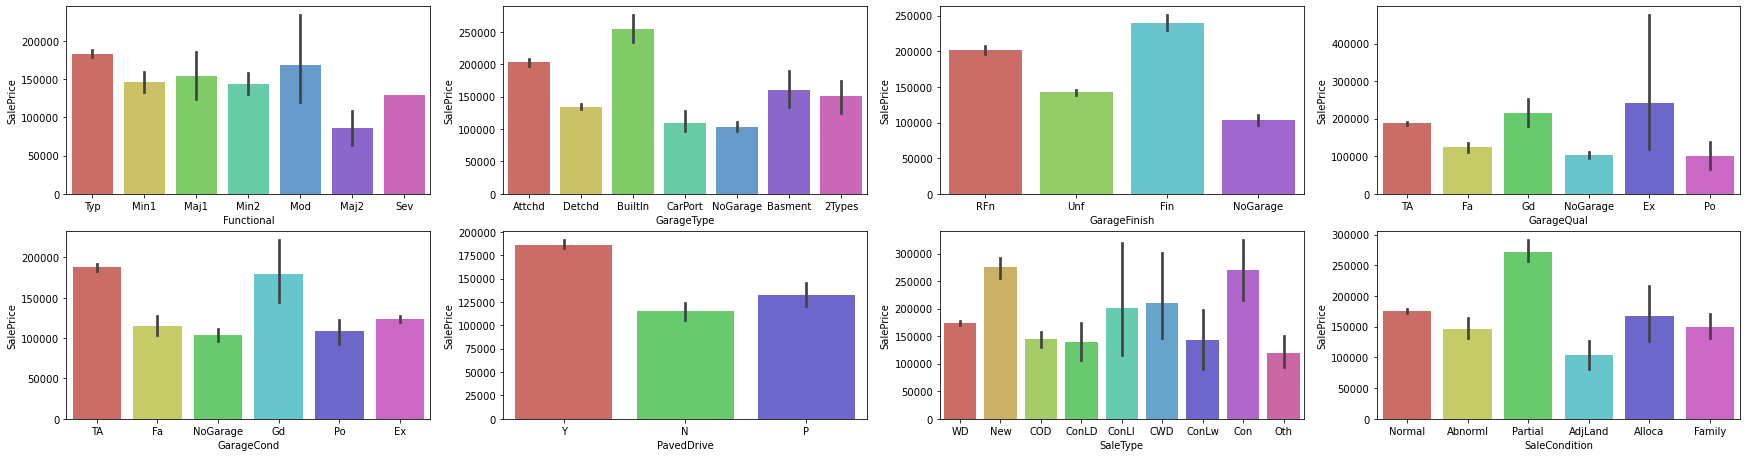

In [32]:
plt.figure(figsize=(30, 20))
plt.subplot(5,4,1)
sns.barplot(x=housing.Functional, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,2)
sns.barplot(x=housing.GarageType, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,3)
sns.barplot(x=housing.GarageFinish, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,4)
sns.barplot(x=housing.GarageQual, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,5)
sns.barplot(x=housing.GarageCond, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,6)
sns.barplot(x=housing.PavedDrive, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,7)
sns.barplot(x=housing.SaleType, y=housing.SalePrice,palette="hls")
plt.subplot(5,4,8)
sns.barplot(x=housing.SaleCondition, y=housing.SalePrice,palette="hls")
plt.show()

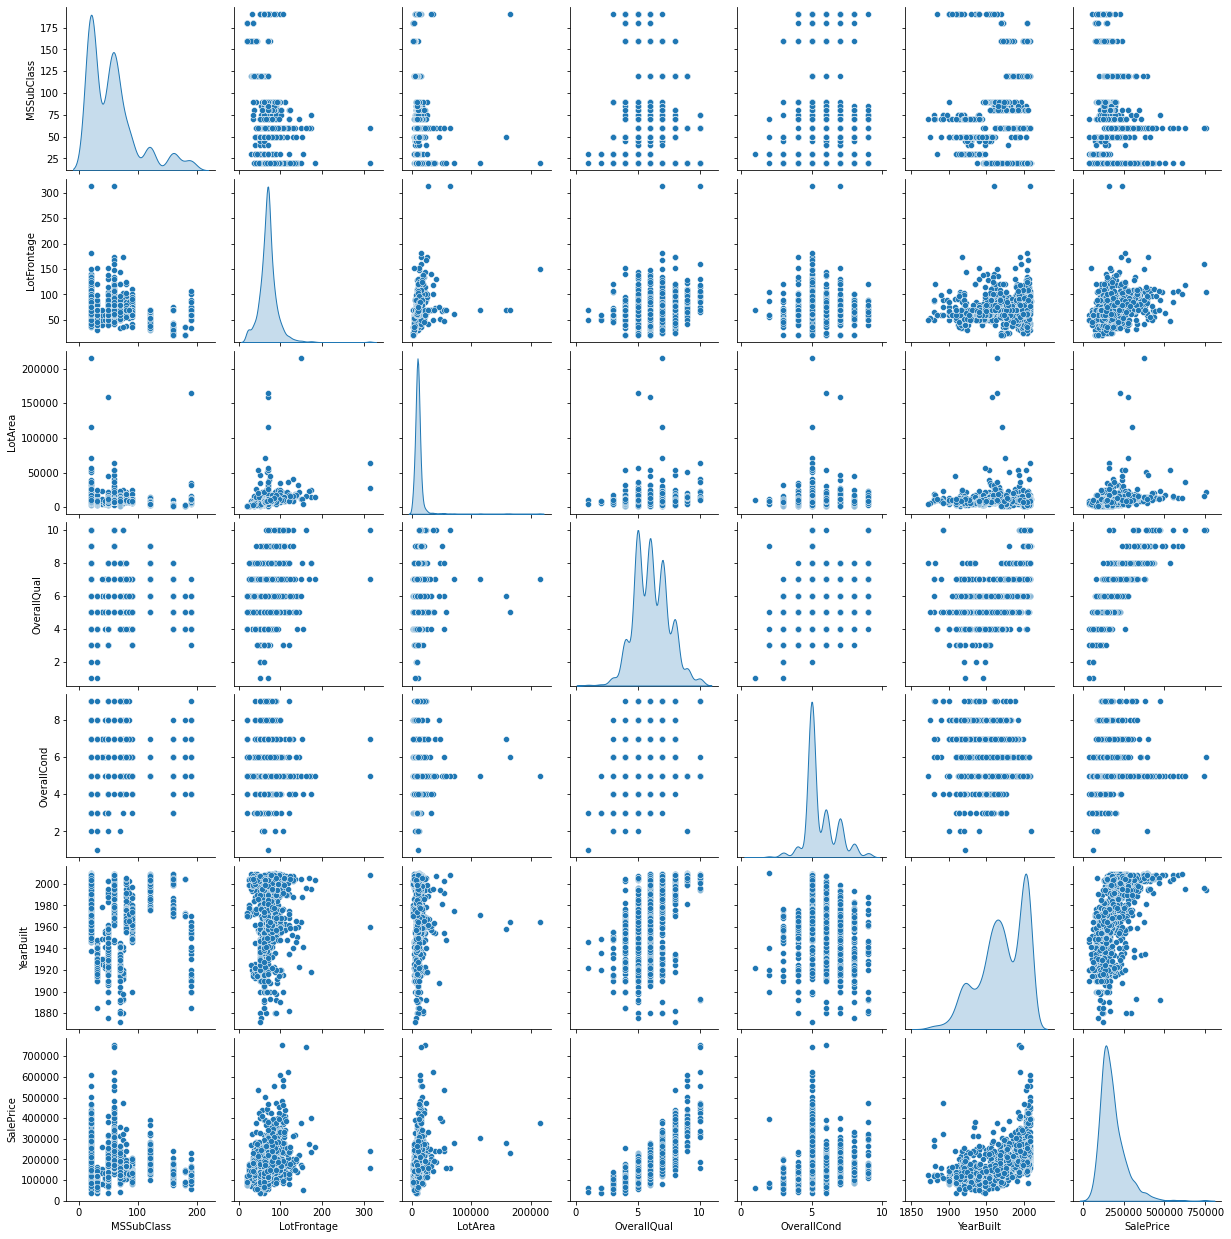

In [33]:
#Analyze continuous(SalePrice) and other continous variables.
cat_cols_set1 = ['MSZoning', 'Street', 'Alley','LotShape', 'LandContour','Utilities']
#cat_cols_set1 = ['MSZoning', 'Street', 'LotShape', 'LandContour','Utilities']
cat_cols_set2 = ['LotConfig', 'LandSlope', 'Neighborhood', 'Condition1','Condition2','BldgType']
cat_cols_set3 = ['HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType']
cat_cols_set4 = ['ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure']
cat_cols_set5 = ['BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC','CentralAir', 'Electrical']
cat_cols_set6 = ['KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual']
#cat_cols_set6 = ['KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual']
cat_cols_set7 = ['GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType', 'SaleCondition','MiscFeature']
#cat_cols_set7 = ['GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

cont_cols_set1 = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']
#cont_cols_set1 = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']
cont_cols_set2 = ['YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
cont_cols_set3 = ['1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath']
cont_cols_set4 = ['FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']
cont_cols_set5 = ['GarageYrBlt', 'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch']
cont_cols_set6 = ['3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


sns.pairplot(housing, vars=cont_cols_set1+['SalePrice'],diag_kind="kde", kind="scatter", palette="husl")
plt.show()



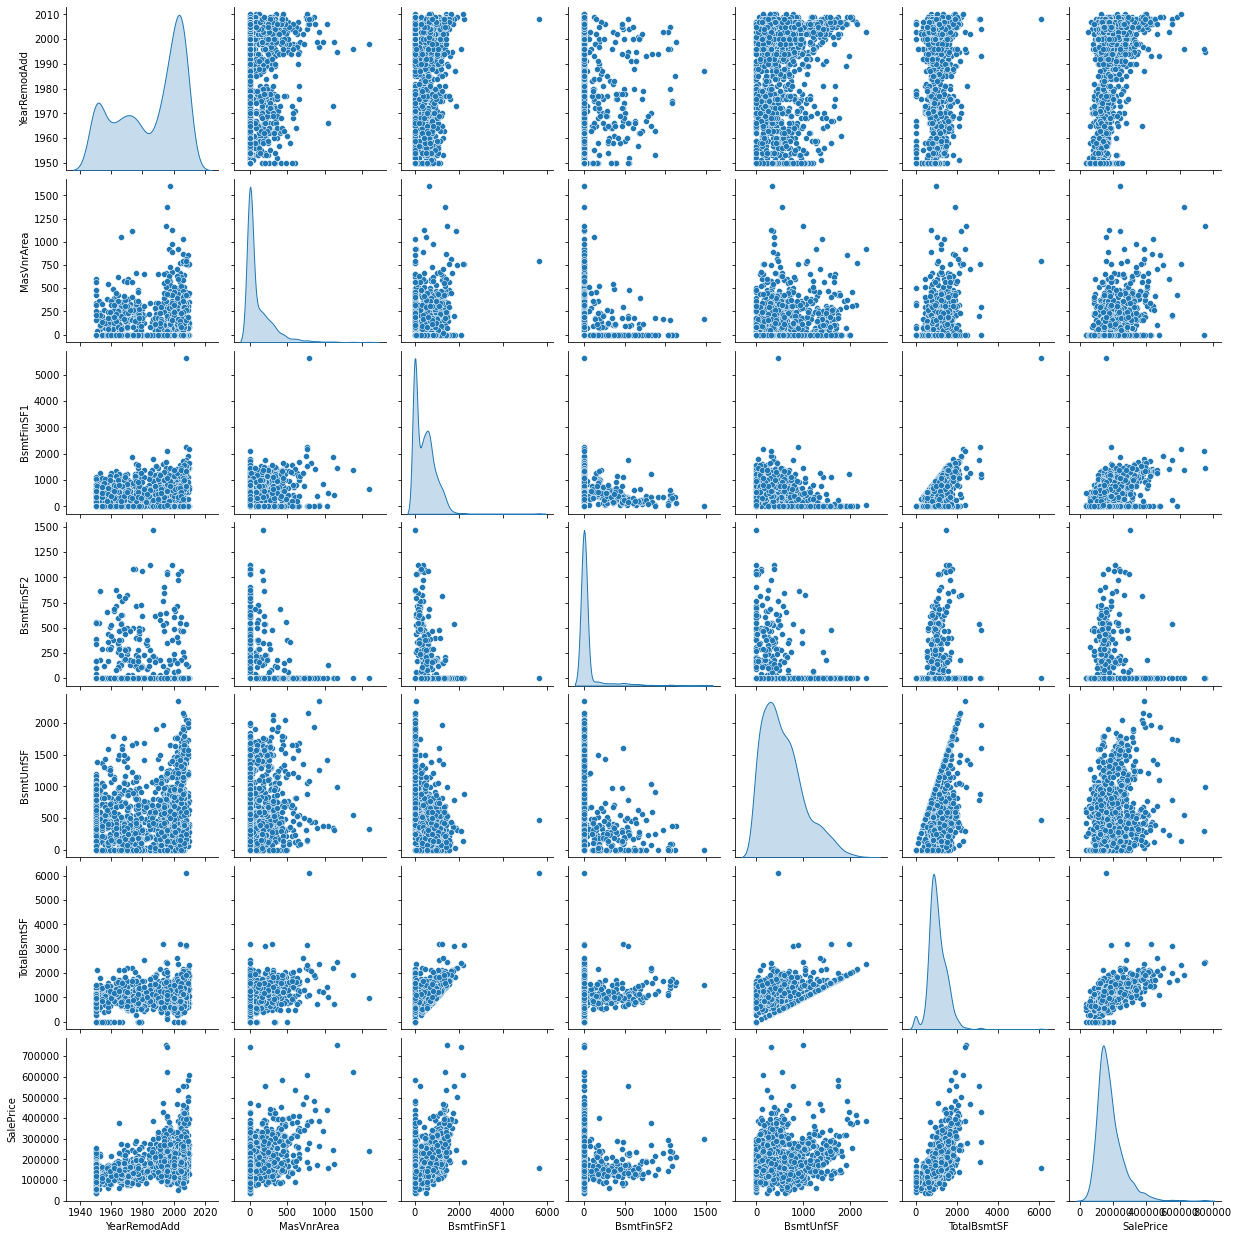

In [34]:
sns.pairplot(housing, vars=cont_cols_set2+['SalePrice'],diag_kind="kde", kind="scatter", palette="husl")
plt.show()

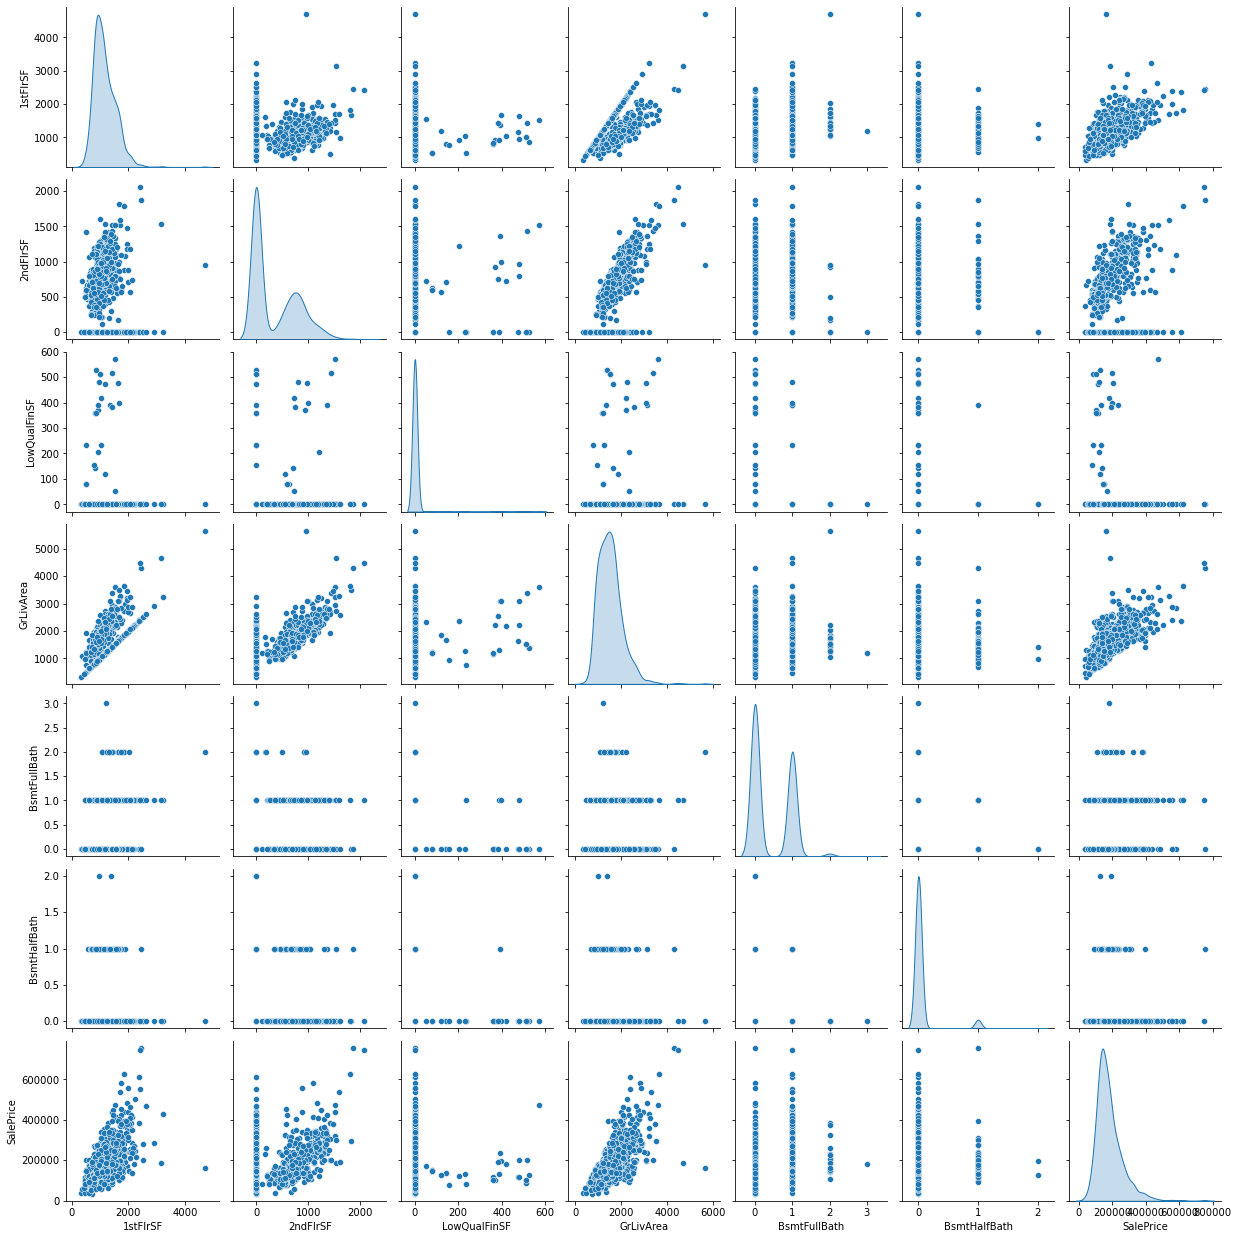

In [35]:
sns.pairplot(housing, vars=cont_cols_set3+['SalePrice'],diag_kind="kde", kind="scatter", palette="husl")
plt.show()


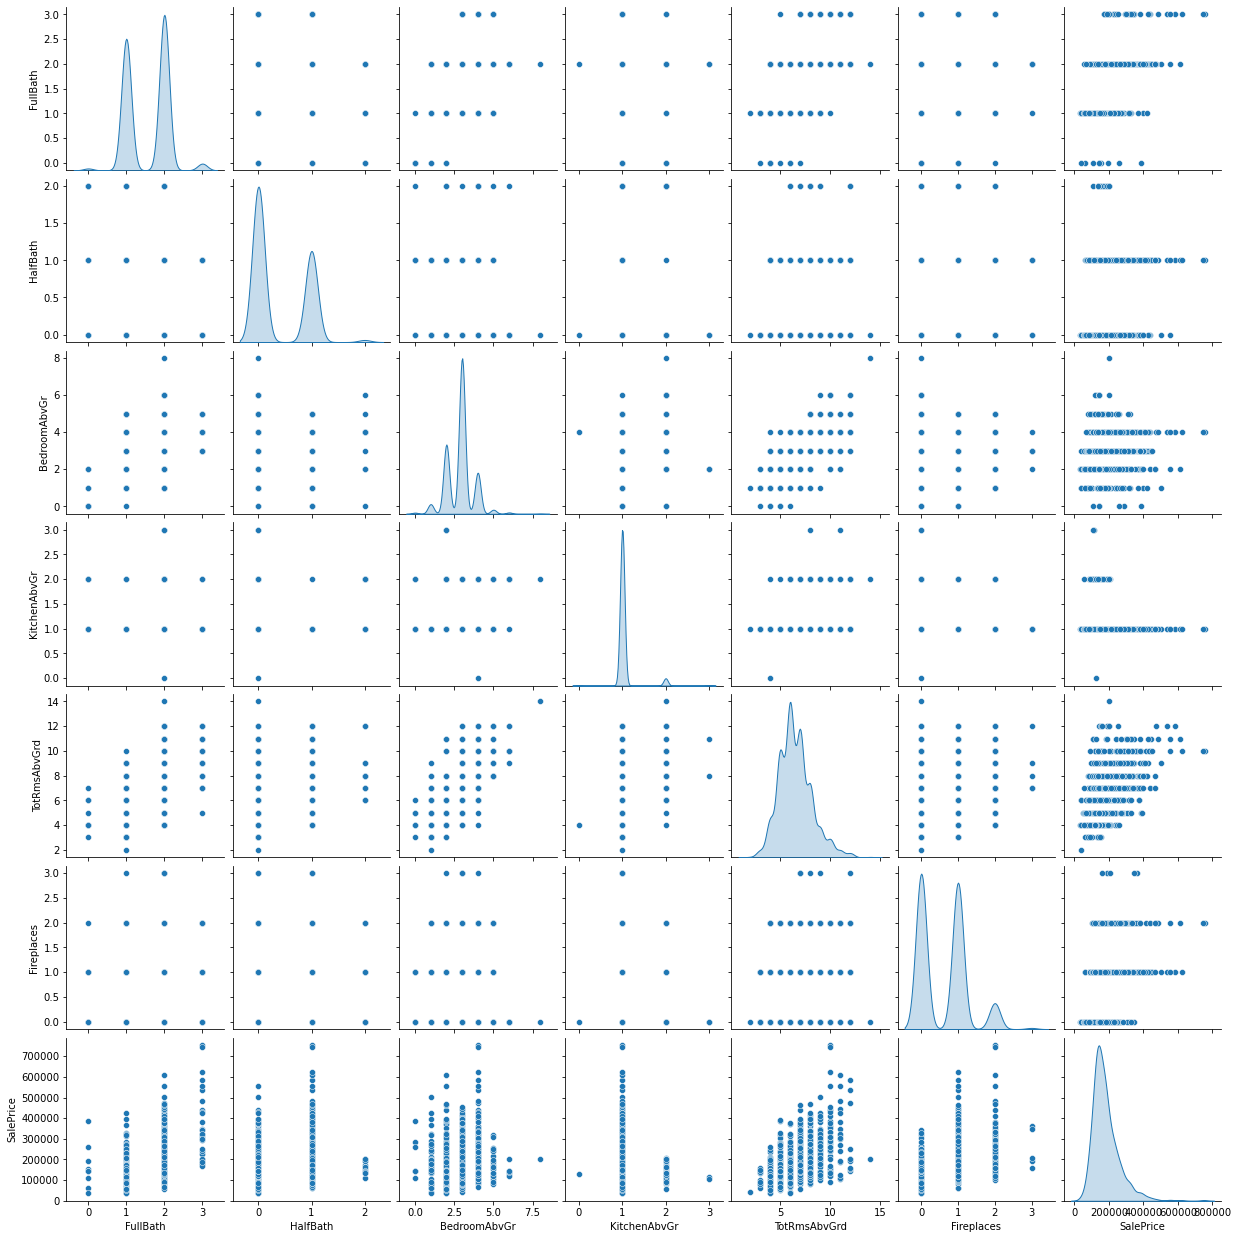

In [36]:
sns.pairplot(housing, vars=cont_cols_set4+['SalePrice'],diag_kind="kde", kind="scatter", palette="husl")
plt.show()

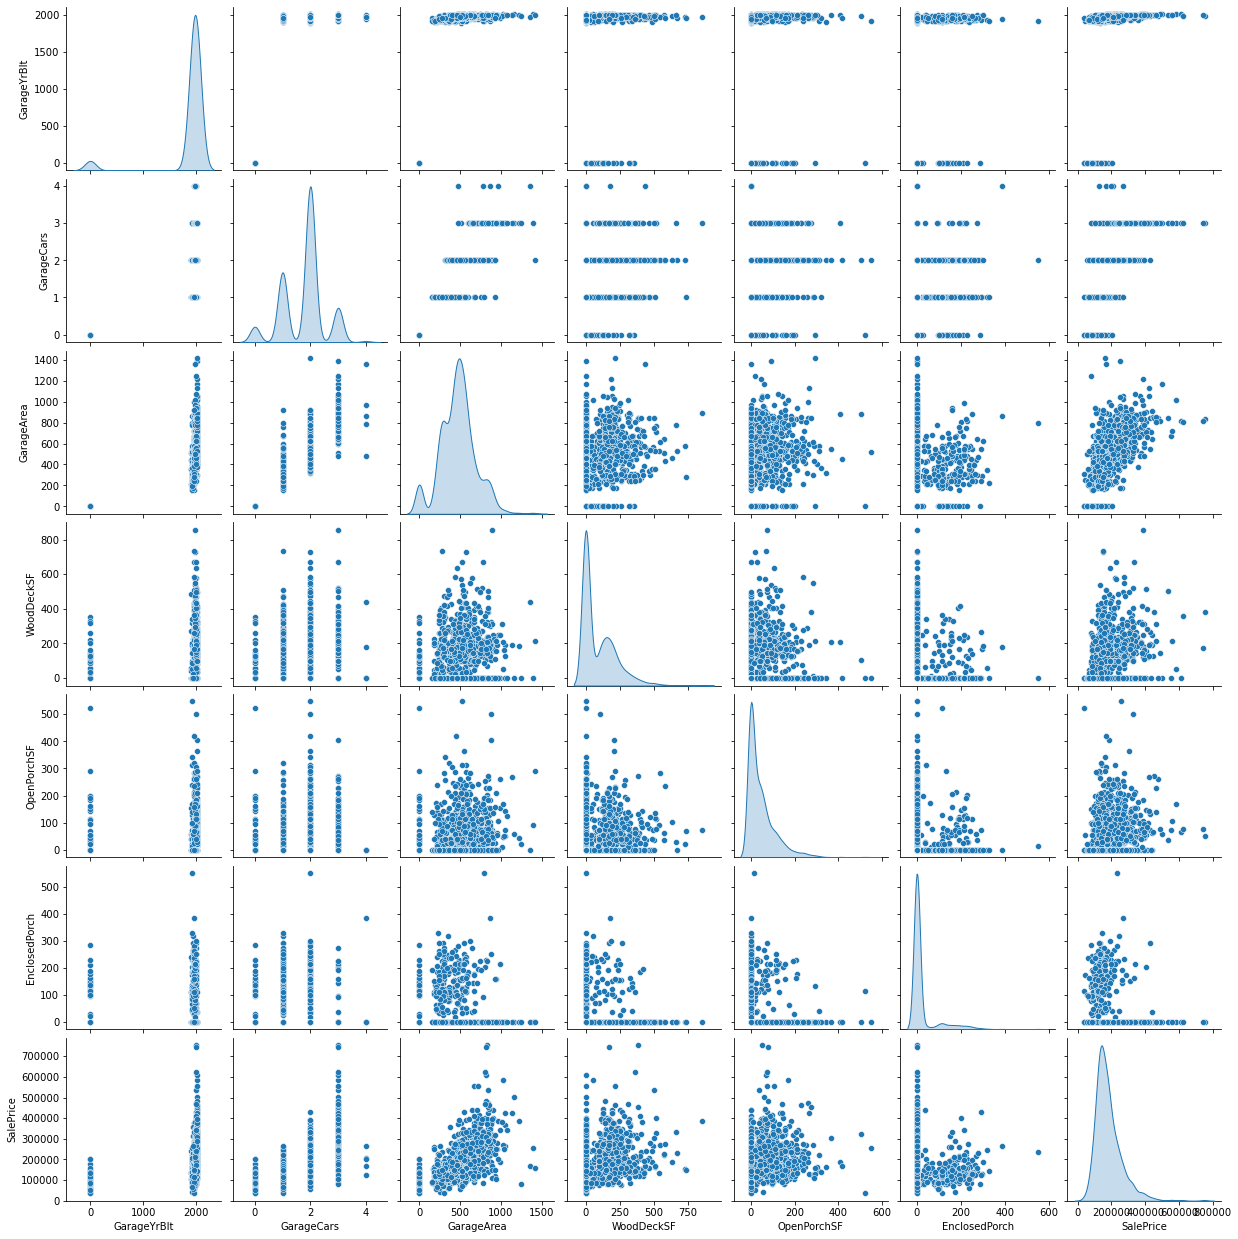

In [37]:
sns.pairplot(housing, vars=cont_cols_set5+['SalePrice'],diag_kind="kde", kind="scatter", palette="husl")
plt.show()


In [38]:
corr = housing.corr()
corr.style.background_gradient(cmap='coolwarm')

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.357042,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022895,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.080997,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.357042,1.000000,0.306689,0.234227,-0.052842,0.117555,0.082775,0.179273,0.215760,0.043298,0.122249,0.363366,0.414246,0.072479,0.036879,0.368376,0.091428,-0.006446,0.180431,0.048209,0.237016,-0.005762,0.320166,0.235636,0.100210,0.269722,0.323658,0.077032,0.137435,0.009814,0.062317,0.037683,0.180867,0.001101,0.010172,0.006750,0.334897
LotArea,-0.139781,0.306689,1.000000,0.105806,-0.005636,0.014228,0.013788,0.103960,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.072599,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.234227,0.105806,1.000000,-0.091932,0.572323,0.550684,0.410238,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.288998,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.052842,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.127788,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.006515,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.117555,0.014228,0.572323,-0.375983,1.000000,0.592855,0.314745,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.272029,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.082775,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.146357,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,0.022895,0.179273,0.103960,0.410238,-0.127788,0.314745,0.179186,1.000000,0.263582,-0.072302,0.114184,0.362452,0.342160,0.174019,-0.069068,0.389893,0.085055,0.026669,0.275730,0.200802,0.102417,-0.037364,0.280027,0.247906,0.133734,0.363778,0.372567,0.159349,0.124965,-0.109849,0.018795,0.061453,0.011723,-0.029815,-0.005940,-0.008184,0.475241
BsmtFinSF1,-0.069836,0.215760,0.214103,0.239666,-0.046231,0.249503,0.128451,0.263582,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.115843,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.043298,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.072302,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,0.035070,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378


<div class="alert alert-info">
    <h1>Analysis</h1>
    <h2>Categorical Predictors</h2>
    Collinearity found and below are some columns:
<ul>
  <li>1stFlrSF and GrLivArea</li>
  <li>2ndFlrSF and GrLivArea</li>
  <li>TotalBsmtSF and BsmtUnfSF</li>  
 </ul>
   <h2>Continuous Predictors</h2>
    <b>Functional,Exterior2nd, ExterCond, GarageQual, SaleType</b> seems to be very less relevant to SalePrice. Probably can be dropped but lets keep it as they are not so off.
    <h2>From the correlation matrix</h2>
    Some of the predictors like OverallQual, GarageCars, GarageArea, TotalBsmtSF, 1stFlrSF seem to be impacting SalePrice.
</div>

In [39]:
housing.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Step 3: Data prepation for model building

### 3.1 Create dummy variable for categorical variables

In [40]:
cat_cols = cat_cols_set1 + cat_cols_set2 + cat_cols_set3 + cat_cols_set4 + cat_cols_set5 + cat_cols_set6+cat_cols_set7
cols_not_to_convert_to_dummy_var = ['Street', 'CentralAir']
cat_cols = list(set(cat_cols) - set(cols_not_to_convert_to_dummy_var))

cat_df = pd.DataFrame(housing, columns=cat_cols)
dummy_cat_df = pd.get_dummies(cat_df, drop_first=True)
housing = pd.concat([housing, dummy_cat_df], axis = 1)
housing = housing.drop(cat_cols, axis=1)
housing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 260 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   MSSubClass               int64  
 1   LotFrontage              float64
 2   LotArea                  int64  
 3   Street                   object 
 4   OverallQual              int64  
 5   OverallCond              int64  
 6   YearBuilt                int64  
 7   YearRemodAdd             int64  
 8   MasVnrArea               float64
 9   BsmtFinSF1               int64  
 10  BsmtFinSF2               int64  
 11  BsmtUnfSF                int64  
 12  TotalBsmtSF              int64  
 13  CentralAir               object 
 14  1stFlrSF                 int64  
 15  2ndFlrSF                 int64  
 16  LowQualFinSF             int64  
 17  GrLivArea                int64  
 18  BsmtFullBath             int64  
 19  BsmtHalfBath             int64  
 20  FullBath                 int64  
 21  HalfBath     

In [41]:
housing.Street = housing.Street.map({"Pave": 0, "Grvl": 1})
housing.CentralAir = housing.CentralAir.map({"Y": 1, "N": 0})
housing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 260 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   MSSubClass               int64  
 1   LotFrontage              float64
 2   LotArea                  int64  
 3   Street                   int64  
 4   OverallQual              int64  
 5   OverallCond              int64  
 6   YearBuilt                int64  
 7   YearRemodAdd             int64  
 8   MasVnrArea               float64
 9   BsmtFinSF1               int64  
 10  BsmtFinSF2               int64  
 11  BsmtUnfSF                int64  
 12  TotalBsmtSF              int64  
 13  CentralAir               int64  
 14  1stFlrSF                 int64  
 15  2ndFlrSF                 int64  
 16  LowQualFinSF             int64  
 17  GrLivArea                int64  
 18  BsmtFullBath             int64  
 19  BsmtHalfBath             int64  
 20  FullBath                 int64  
 21  HalfBath     

### 3.2 Scaler the data

In [42]:
# Tried both MinMaxScaler and StandardScaler and later seems to be giving marginally better results.
scaler = StandardScaler()
cols = housing.columns
housing[cols] = scaler.fit_transform(housing[cols])
housing.columns = cols

X = housing.drop(['SalePrice'], axis=1)
y = housing['SalePrice']
housing.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 260 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   MSSubClass               float64
 1   LotFrontage              float64
 2   LotArea                  float64
 3   Street                   float64
 4   OverallQual              float64
 5   OverallCond              float64
 6   YearBuilt                float64
 7   YearRemodAdd             float64
 8   MasVnrArea               float64
 9   BsmtFinSF1               float64
 10  BsmtFinSF2               float64
 11  BsmtUnfSF                float64
 12  TotalBsmtSF              float64
 13  CentralAir               float64
 14  1stFlrSF                 float64
 15  2ndFlrSF                 float64
 16  LowQualFinSF             float64
 17  GrLivArea                float64
 18  BsmtFullBath             float64
 19  BsmtHalfBath             float64
 20  FullBath                 float64
 21  HalfBath     

### 3.3 Split into train and split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3,
                                                    random_state=100)

## 4. Model Building and Evaluation

### Linear Regression
Let's see how linear regression looks like.

In [44]:
lm = LinearRegression()

lm.fit(X_train, y_train)
print(lm.intercept_)
print(lm.coef_)
from sklearn.metrics import r2_score, mean_squared_error

-2069048795.3411493
[-1.59646545e-02  2.67116603e-02  9.21418208e-02 -2.63053451e-02
  1.17360774e-01  7.14923952e-02  1.45783293e-01  4.07028152e-02
  5.38256912e-02  3.42633505e+11  1.21187501e+11  3.31942682e+11
 -3.29567578e+11 -4.28434691e-04  4.11078422e+10  4.64182908e+10
  5.17033978e+09 -5.58770043e+10  1.27871959e-02  1.20031844e-03
  4.16054621e-03 -1.99916903e-02 -3.55353344e-02 -5.05240632e-02
 -1.01463510e-02  1.60404253e-02 -1.34703629e-02  3.69797727e-02
  3.30075909e-02  1.74281973e-02  1.95531227e-02  1.11450828e-02
  7.19504074e-03  1.09081037e-02  3.10684973e+00  4.43977746e-02
 -1.01208292e-02 -1.45067787e-02 -3.14631600e-02 -7.53180933e-03
 -2.60358087e-02 -4.78983117e-02 -2.86960654e-02 -3.13856678e-02
 -9.75952404e-03 -6.33927892e-03  6.92579783e-03 -2.14294437e-01
 -1.60299570e-02 -5.60924951e-03  5.85502338e-03 -5.57594157e-03
 -1.14780567e-01 -1.32460206e-01  2.30385026e-02  6.00132883e-03
  5.28603662e-03 -1.13354882e-02  2.47182783e-02 -2.82309271e-03
  1.7

In [45]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9533490759006193
-4.986378231957744e+21
47.19763337031664
2.2285774468698033e+24
0.04622686911882139
5.088076362716445e+21


### Ridge and Lasso Regression¶
Let's now try predicting house prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

In [46]:
from sklearn.model_selection import GridSearchCV
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0, 50.0, 100.0,500.0,1000.0 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.5s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0,
                                   50.0, 100.0, 500.0, 1000.0]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [47]:
print(model_cv.best_params_)

{'alpha': 100.0}


In [48]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 100
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)
print(ridge.coef_)

[-3.98398426e-02  1.73340747e-02  5.49610760e-02 -1.85361506e-02
  1.31658728e-01  5.84643483e-02  5.88907541e-02  4.22328770e-02
  5.58617663e-02  6.68973654e-02  1.72800793e-02  1.08932917e-02
  8.68755266e-02  7.93153960e-03  9.48470430e-02  1.18056924e-01
 -2.16464608e-02  1.65847087e-01  2.79276097e-02 -2.27147691e-03
  4.18083485e-02  1.35046063e-02 -2.11393310e-02 -3.57174901e-02
  3.70286087e-02  3.54117124e-02 -2.03780079e-03  5.44744879e-02
  3.40440222e-02  1.86701689e-02  1.83722158e-02 -5.53161271e-03
  1.00090195e-02  1.13040376e-02  3.96672434e-02 -1.37428050e-04
 -6.21817586e-03 -8.16913154e-03 -1.74160665e-02  3.28537685e-03
 -1.40706372e-02 -6.78840092e-03 -1.65925073e-02 -5.24667403e-03
  8.86720717e-03  1.85042160e-02  1.97387509e-02 -1.45906007e-01
 -1.11179822e-02  3.60277159e-03  1.15539081e-02 -2.17362996e-03
 -3.69207895e-02 -5.67548472e-02 -2.83938819e-03  5.77520700e-03
 -4.49276199e-04 -1.65193479e-02  9.54556601e-03  3.59279342e-03
  8.60955086e-03 -1.56872

In [49]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9383855774264673
0.7132236680256564
62.33649135769129
128.16983309409846
0.06105435000753309
0.2926251897125536


### Lasso

In [50]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.6s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20.0,
                                   50.0, 100.0, 500.0, 1000.0]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [51]:
print(model_cv.best_params_)

{'alpha': 0.01}


In [52]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha =0.01
lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.01)

In [53]:
lasso.coef_

array([-4.72401888e-02,  1.85576542e-02,  4.13351309e-02, -9.76574107e-03,
        1.68605304e-01,  6.06066029e-02,  1.12034943e-01,  4.61022629e-02,
        4.12470449e-02,  8.19242993e-02,  0.00000000e+00, -0.00000000e+00,
        1.08497640e-01,  0.00000000e+00,  0.00000000e+00,  2.93850786e-03,
       -2.76015892e-02,  4.07701863e-01,  1.75051293e-02, -0.00000000e+00,
        2.79969214e-03,  0.00000000e+00, -2.46490200e-02, -4.42539975e-02,
        0.00000000e+00,  1.64047341e-02, -0.00000000e+00,  2.52288616e-02,
        2.94977625e-02,  7.80967141e-03,  7.13845374e-03, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.59210921e-02, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -4.74177814e-04,  3.45596363e-03,
       -3.15863026e-03,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  8.56341370e-03, -1.76843658e-01,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -

In [54]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9316668925430674
0.5620879110803602
69.13391353054826
195.7174044325933
0.06771196232179065
0.4468433891155098


In [55]:
model_parameter = list(ridge.coef_)
model_parameter.insert(0,ridge.intercept_)
cols = X_train.columns
cols.insert(0,'constant')
ridge_coef = pd.DataFrame(list(zip(cols,model_parameter)))
print("          Top 5 predictor using Ridge regularization")
print(ridge_coef.sort_values(1,ascending=False).head(5))

          Top 5 predictor using Ridge regularization
               0         1
18  BsmtFullBath  0.165847
5    OverallCond  0.131659
16  LowQualFinSF  0.118057
15      2ndFlrSF  0.094847
13    CentralAir  0.086876


In [56]:
model_parameter = list(lasso.coef_)
model_parameter.insert(0,lasso.intercept_)
cols = X_train.columns
cols.insert(0,'constant')
lasso_coef = pd.DataFrame(list(zip(cols,model_parameter)))
print("          Top 5 predictor using Lasso regularization")
print(lasso_coef.sort_values(1,ascending=False).head(5))

          Top 5 predictor using Lasso regularization
               0         1
18  BsmtFullBath  0.407702
5    OverallCond  0.168605
7   YearRemodAdd  0.112035
13    CentralAir  0.108498
10    BsmtFinSF2  0.081924



<div class="alert alert-success">
    <h1>Conclusion</h1>
    Following top 5 predictors are significant in predicting SalePrice
<h2>Ridge</h2>
<ul>
  <li>BsmtFullBath</li>
  <li>OverallCond</li>
  <li>LowQualFinSF</li> 
  <li>2ndFlrSF</li>
  <li>CentralAir</li> 
</ul>
    
<h2>Lasso</h2>
<ul>
  <li>BsmtFullBath</li>
  <li>OverallCond</li>
  <li>YearRemodAdd</li> 
  <li>CentralAir</li>
  <li>BsmtFinSF2</li>     
</div>
